In [1]:
import pickle
from pprint import pprint
import pandas as pd
pd.set_option("display.notebook_repr_html", False)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dcss.text import bigram_process, preprocess, bow_to_df
from dcss.plotting import format_axes_commas, custom_seaborn
from dcss.utils import sparse_groupby
custom_seaborn()
import spacy
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import scipy

In [2]:
with open ('../data/pickles/processed_sample_british_party_subset_hansards.pkl','rb') as fp:
    preprocessed = pickle.load(fp)
tfidf_vectorizer = TfidfVectorizer(max_df=.1, min_df=3, strip_accents='ascii')
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed)
tfidf_matrix.shape

(2576, 3713)

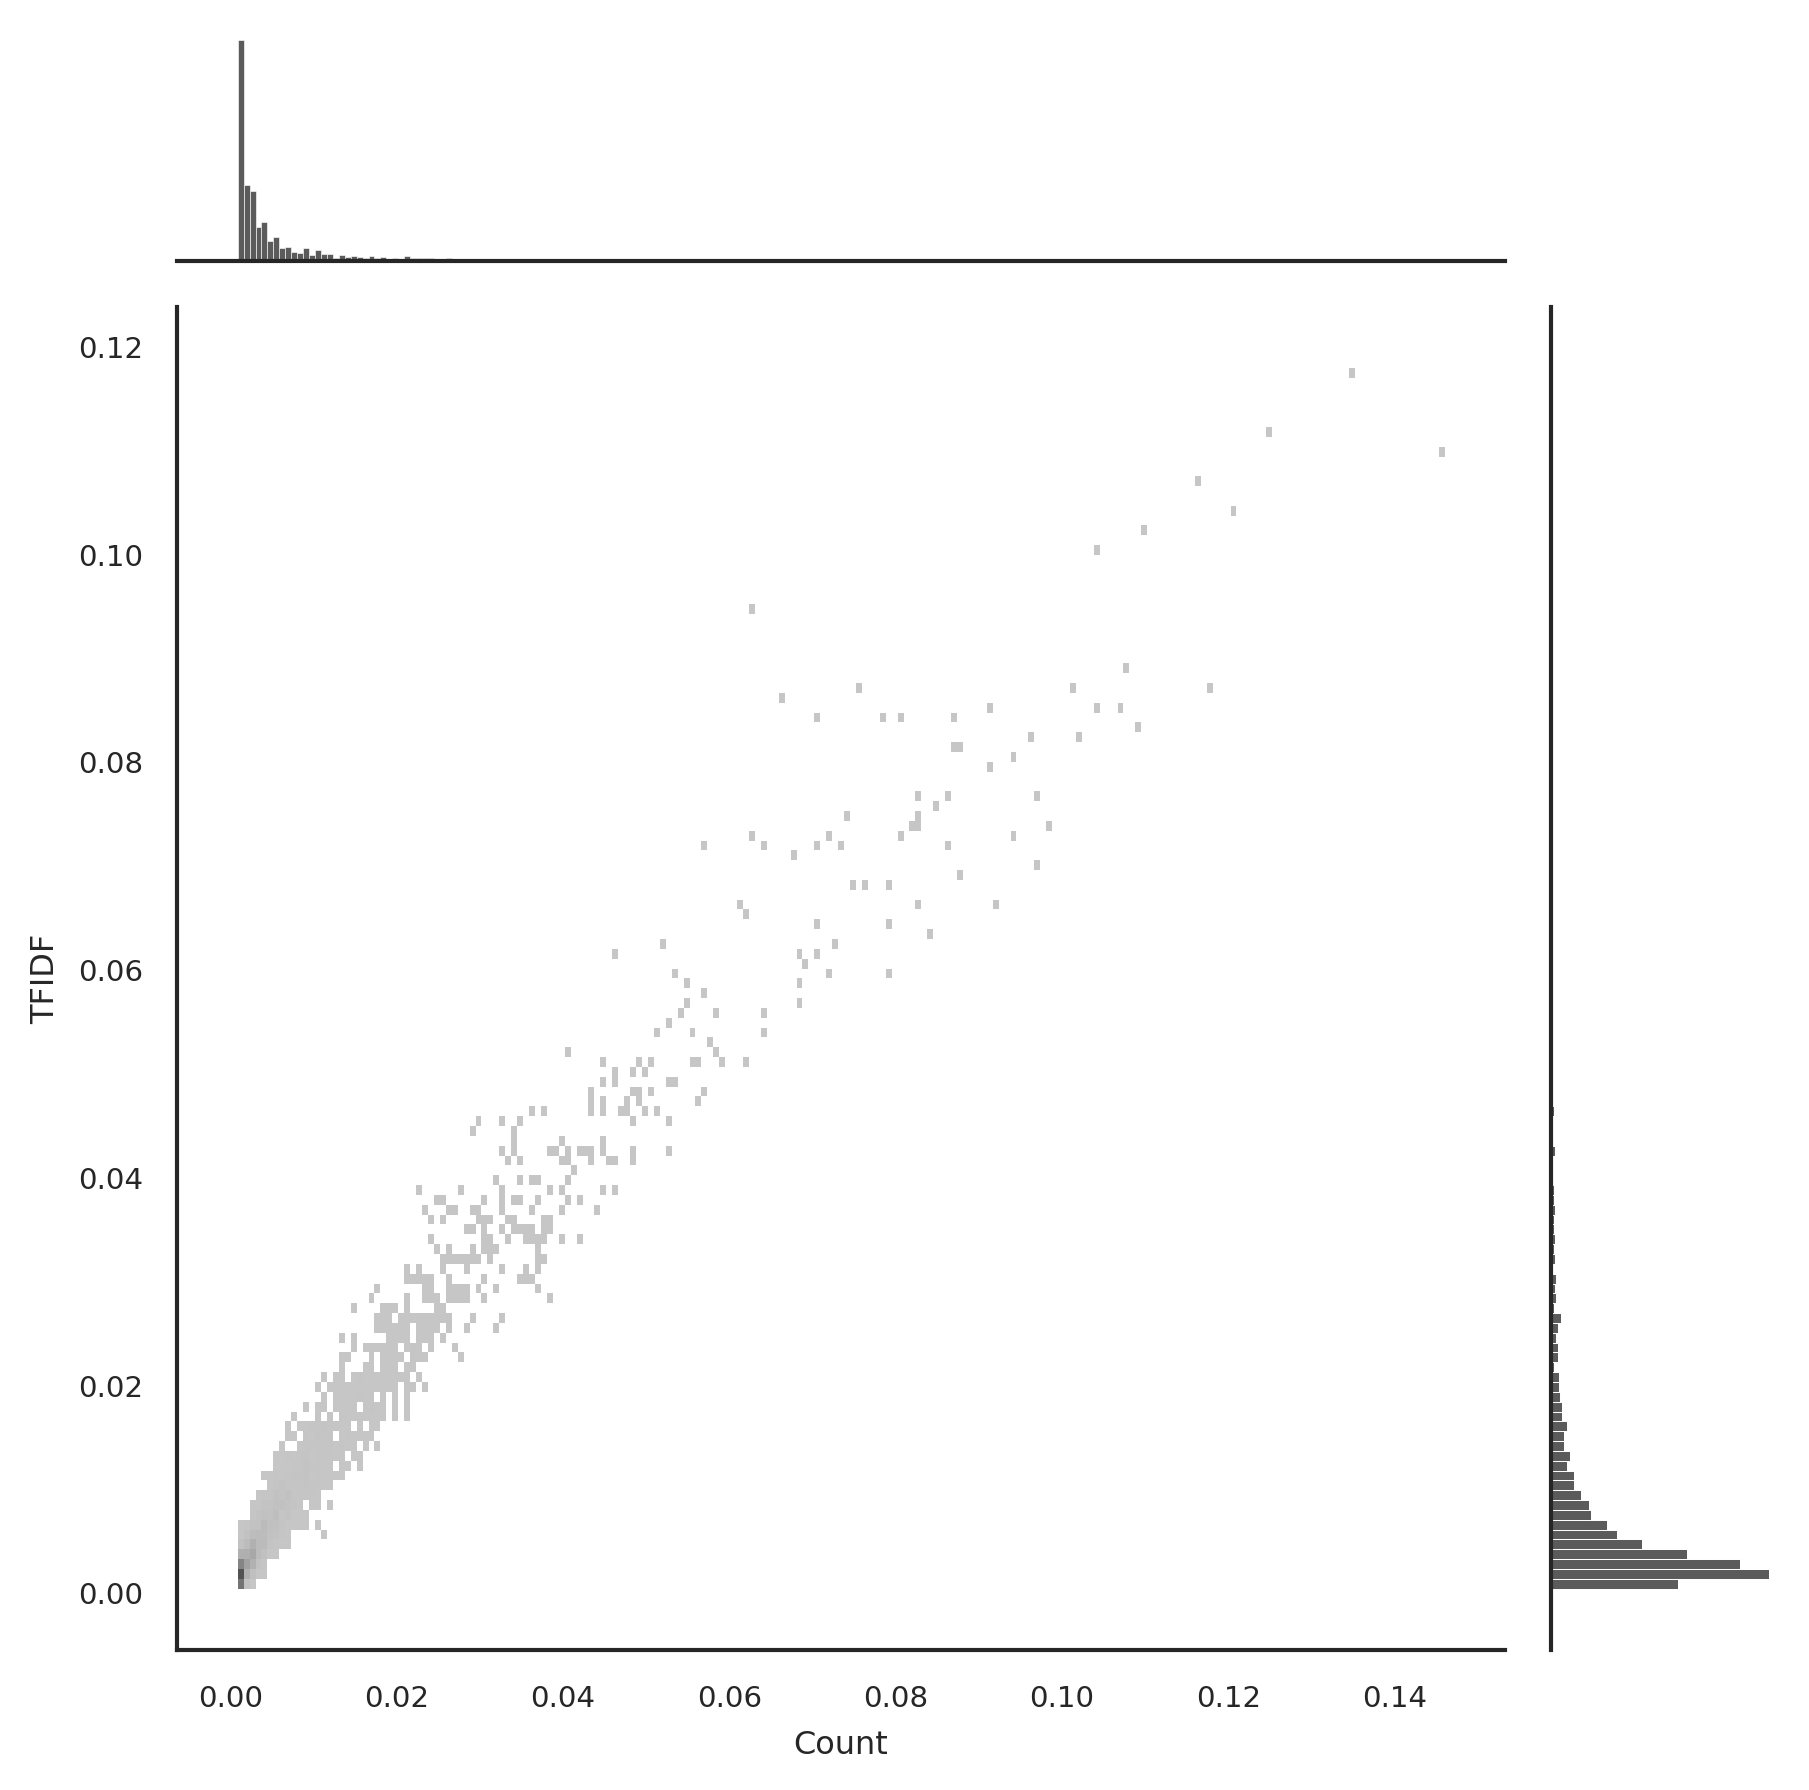

In [4]:
with open ('../data/pickles/brit_hansards_sample_party_subset_count_matrix.pkl', 'rb') as fp:
    count_matrix = pickle.load(fp)
tfidf_scores = np.ravel(tfidf_matrix.sum(0))
tfidf_scores = tfidf_scores/np.linalg.norm(tfidf_scores)
term_counts = np.ravel(count_matrix.sum(0))
term_counts = term_counts/np.linalg.norm(term_counts)
vocabulary = tfidf_vectorizer.get_feature_names_out()
df = pd.DataFrame({'Term': vocabulary, 'TFIDF': tfidf_scores, 'Count': term_counts})
df.sort_values(by='TFIDF', ascending=False, inplace=True)
sns.jointplot(data=df.head(5000), x='Count', y='TFIDF', kind='hist')
plt.show()

In [5]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='ascii', sublinear_tf=True)
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed)
tfidf_matrix.shape

(2576, 10504)

In [7]:
with open ('../data/pickles/sampled_british_hansard_speeches.pkl', 'rb') as fp:
    speech_df = pickle.load(fp)
party_names = speech_df['party']
tfidf_vocabulary = tfidf_vectorizer.get_feature_names_out()
party_scores = sparse_groupby(party_names, tfidf_matrix, tfidf_vocabulary)
len(party_names)

2576

In [8]:
normalize = Normalizer()
party_scores_n = normalize.fit_transform(party_scores)

In [9]:
sim_matrix = party_scores_n @ party_scores_n.T
sim_df = pd.DataFrame.sparse.from_spmatrix(sim_matrix).sparse.to_dense()

In [10]:
np.fill_diagonal(sim_df.values, np.nan) 
sim_df.values[np.tril_indices(sim_df.shape[0], -1)] = np.nan

In [11]:
sim_df.index = party_scores.index
sim_df.columns = party_scores.index

In [12]:
print(sim_df.stack().nlargest(3))

Labour            Liberal Democrat           0.895885
Liberal Democrat  Scottish National Party    0.863325
Labour            Scottish National Party    0.858064
dtype: float64


In [16]:
party_scores_df = pd.DataFrame.sparse.from_spmatrix(party_scores_n)
party_scores_df.index = party_scores.index
party_scores_df.columns = tfidf_vectorizer.get_feature_names_out()
for party in ['Labour','Liberal Democrat','Democratic Unionist Party','Plaid Cymru']:
    print(party + '\n')
    print(party_scores_df.loc[party].nlargest(10))
    print('\n')

Labour



AttributeError: 'SparseDtype' object has no attribute 'itemsize'